<a href="https://colab.research.google.com/github/DhruvDutta/DataScienceProjects/blob/main/vehicle_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import cv2,glob
import numpy as np
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [ ]:
#!gdown --id 1xje2dv5Tv4Viknhb1jepG2xG8MCnqcFC #https://drive.google.com/file/d/1xje2dv5Tv4Viknhb1jepG2xG8MCnqcFC/view?usp=sharing

In [ ]:
#!unzip '/content/vehicle_detection.zip' -d '/content/'

In [ ]:
classes=['bus','rickshaw','motorbike','car','ignore']

In [ ]:
img_size=256
mx_annots=64
train_dir = '/content/train/Final Train Dataset/'
X=[]
y=[]
raw=[0]*len(classes)
for name in sorted(glob.glob(train_dir+"*.jpg"))[200:1700]:
  #print(name)
  image = cv2.imread(name)[:,:,::-1]
  xratio=img_size/image.shape[1]
  yratio=img_size/image.shape[0]
  image = cv2.resize(image, dsize=(img_size, img_size))
  data = np.asarray(image)
  
  X.append(data)
  #with open(name.replace('.jpg','.xml')) as annot_file:
  #  print(''.join(annot_file.readlines()))
  tree = ET.parse(name.replace('.jpg','.xml'))
  root = tree.getroot()
  annots=[]
  for neighbor in root.iter('object'):
    cls = neighbor.find('name').text
    if cls not in classes:
      continue
    neighbor = neighbor.find('bndbox')
    xmin = int(int(neighbor.find('xmin').text)*xratio)
    ymin = int(int(neighbor.find('ymin').text)*yratio)
    xmax = int(int(neighbor.find('xmax').text)*xratio)
    ymax = int(int(neighbor.find('ymax').text)*yratio)

    annots.append([classes.index(cls),xmin, ymin, xmax, ymax])
    if len(annots)>=mx_annots:
        break
  for i in range(abs(mx_annots-len(annots))):
    annots.append([-1,0,0,0,0])
  annots=annots[:mx_annots]
  #print(len(annots))

    #print(annots)
  if annots==[]:
    X.pop()
    continue
  y.append(annots)
  #img = cv2.imread(name)
  #gray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  #for bbox in annots:
    #print(bbox)
  #  cv2.rectangle(img, (bbox[1], bbox[2]), (bbox[3], bbox[4]), (255, 0, 0), 2)
  #cv2_imshow(img)
  del image,data,tree,root,annots,neighbor
X=np.array(X)
y=np.array(y)

In [ ]:
X.shape,y.shape

((1500, 256, 256, 3), (1500, 64, 5))

In [ ]:
X=X/X.max()

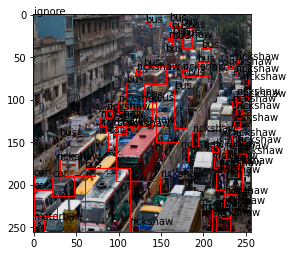

In [ ]:
curr=X[1].copy()
annots=y[1]
fig, ax = plt.subplots()
plt.imshow(curr)
for annot in annots:
  rect = patches.Rectangle((annot[1],annot[2]), annot[3]-annot[1],annot[4]-annot[2], linewidth=1, edgecolor='r', facecolor='none')
  plt.text(annot[1],annot[2],classes[annot[0]])
  ax.add_patch(rect)

plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2,random_state=8)
Xtrain.shape,ytrain.shape,Xtest.shape,ytest.shape

((1200, 256, 256, 3), (1200, 64, 5), (300, 256, 256, 3), (300, 64, 5))

In [ ]:
import tensorflow as tf
earlyStopper=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, verbose=1, mode='auto',restore_best_weights=True)

In [ ]:
model=tf.keras.Sequential(name='vehicle_det')

model.add(tf.keras.layers.Conv2D(16,(3,3),padding='same',activation='relu',input_shape=(img_size,img_size,3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(tf.keras.layers.Conv2D(16,(3,3),padding='same',activation='relu',))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(tf.keras.layers.Conv2D(16,(3,3),padding='same',activation='relu',))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1280,activation='relu',))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(640,activation='relu',))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(320,activation='relu',))
model.add(tf.keras.layers.Reshape((64,5)))


In [ ]:
# compile model 
model.compile(optimizer='adam',loss='mean_squared_error',)

In [ ]:
model.summary()

Model: "vehicle_det"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      2320      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 16)     64        
 hNormalization)                                                 
                                                       

In [ ]:
history=model.fit(x=Xtrain,y=ytrain,verbose=2,epochs=25,validation_split=0.2,callbacks=[earlyStopper],batch_size=16)

Epoch 1/25
60/60 - 7s - loss: 595.0782 - val_loss: 842.9543 - 7s/epoch - 113ms/step
Epoch 2/25
60/60 - 2s - loss: 478.4813 - val_loss: 735.7795 - 2s/epoch - 28ms/step
Epoch 3/25
60/60 - 2s - loss: 409.4218 - val_loss: 693.4202 - 2s/epoch - 28ms/step
Epoch 4/25
60/60 - 2s - loss: 360.0416 - val_loss: 723.5938 - 2s/epoch - 27ms/step
Epoch 5/25
60/60 - 2s - loss: 319.0402 - val_loss: 699.4454 - 2s/epoch - 27ms/step
Epoch 6/25
60/60 - 2s - loss: 286.6461 - val_loss: 613.7818 - 2s/epoch - 28ms/step
Epoch 7/25
60/60 - 2s - loss: 261.7066 - val_loss: 626.4182 - 2s/epoch - 31ms/step
Epoch 8/25
60/60 - 2s - loss: 241.2705 - val_loss: 605.2078 - 2s/epoch - 30ms/step
Epoch 9/25
60/60 - 2s - loss: 240.0369 - val_loss: 582.4397 - 2s/epoch - 28ms/step
Epoch 10/25
60/60 - 2s - loss: 227.5686 - val_loss: 586.7875 - 2s/epoch - 27ms/step
Epoch 11/25
60/60 - 2s - loss: 212.6499 - val_loss: 546.1413 - 2s/epoch - 28ms/step
Epoch 12/25
60/60 - 2s - loss: 204.2924 - val_loss: 600.7659 - 2s/epoch - 27ms/step


In [ ]:
#plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])

#plt.legend(['loss', 'val_loss'], loc='upper left')

In [ ]:
model.evaluate(Xtest,ytest)

10/10 [==============================] - 1s 26ms/step - loss: 449.2677


449.2676696777344

In [ ]:
train_dir = '/content/test1/test/'
X=[]
y=[]
for name in sorted(glob.glob(train_dir+"*.jpg"))[5:10]:
  image = cv2.imread(name)[:,:,::-1]
  image = cv2.resize(image, dsize=(img_size, img_size))
  data = np.asarray(image)
  pred=model.predict(data.reshape(-1,img_size,img_size,3))[0]
  fig, ax = plt.subplots()
  plt.imshow(data)
  for annot in pred:
    rect = patches.Rectangle((annot[1],annot[2]), annot[3]-annot[1],annot[4]-annot[2], linewidth=1, edgecolor='r', facecolor='none')
    if classes[int(annot[0])]=='ignore':
      continue
    plt.text(annot[1],annot[2],classes[int(annot[0])])
    ax.add_patch(rect)